In [1]:
# dowload before running

import nltk

nltk.download('wordnet')

# comment this after frist run

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from nltk.stem import WordNetLemmatizer

## Preprocessing and Balance Analysis

### Loading datasets and joining them

In [3]:
df_true = pd.read_csv("./db/True.csv",sep=',')
df_false = pd.read_csv("./db/Fake.csv",sep=',')

In [4]:
df_true['real'] = 1
df_false['real'] = 0

In [5]:
df = pd.concat([df_true,df_false])
df = df.drop(['date'], axis=1) # Not relevant. Check reference for clarification.

In [6]:
df.head()

,title,text,subject,real
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


### Defining pre-processing function

When working with text-based classifiers, it's important to clear them of expressions and words that provide little to no context or relevant information for classification.
In this step, the text is converted to lowercase, stop words are removed and then the text is lemmatised.

In [7]:
def pre_process_text_fields(df, cols):
    pre_df = df.copy(deep=True)
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    pre_df[cols] = pre_df[cols].apply(lambda x: x.apply(lambda x: ' '.join([lemmatizer.lemmatize(p) for p in x.lower().split()])))

    return pre_df

In [8]:
df = pre_process_text_fields(df, ['title', 'text'])

### Removing Tag-Like String from Text Collumn

When first looking at the data, a tag-like phrase appeared in the text field - This 'tag' references the origin of the text, and will introduce bias if left in this field. 
As such, it'll be removed from the text collumn and a origin collumn will be created to store it for precaution.

In [9]:
df["origin"] = df["text"].apply(lambda x: x.split("-")[0])
df["text"] = df["text"].apply(lambda x: 
    x if len(x.split("-")) <= 1
    else x.split("-")[1]
)

## Distribution analysis

### Subject/Topic 

In order assure the model can be retrained and the dataset augmented with external data, a subject/topic generalization will be conducted. Keeping the process simple, the fake news are to be separated between world news and politic news to fit with the topics delineated in the real news.

In [10]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['text_len'] = df['text'].apply(lambda x: len(x))

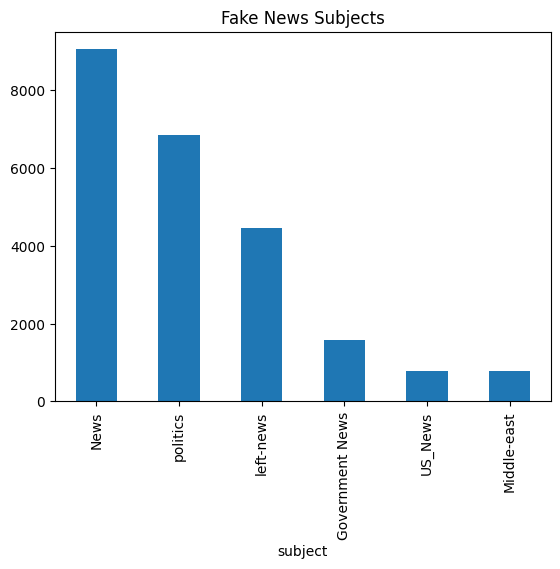

In [11]:
fake = df["real"] == 0
df[fake]["subject"].value_counts().plot(kind='bar')
plt.title("Fake News Subjects")
plt.show()

In [12]:
df['subject'] = df['subject'].apply(lambda x: 'politicsNews' if x in ['politics', 'left-news'] else x)
df['subject'] = df['subject'].apply(lambda x: 'worldnews' if x in ['News', 'Government News', 'US_News', 'Middle-east'] else x)

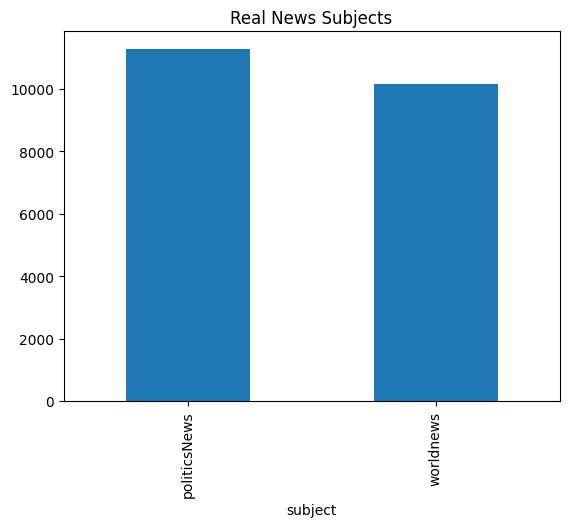

In [13]:
df[~fake]["subject"].value_counts().plot(kind='bar')
plt.title("Real News Subjects")
plt.show()

### Evaluating size distribution

This section has no impact in the final model. The goal is to check for other possible metrics to be used in future interations, such as text and title size.

<Axes: ylabel='Frequency'>

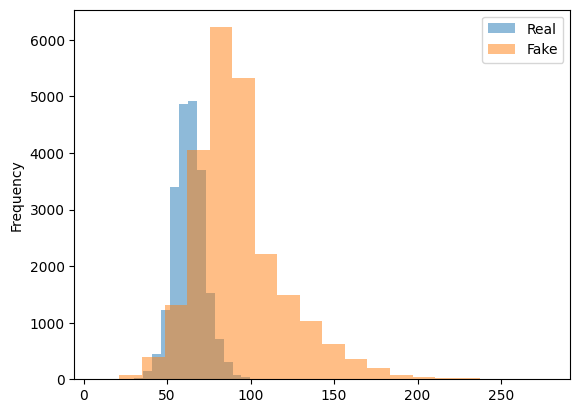

In [14]:
df[~fake]['title_len'].plot(kind='hist', bins=20, alpha=0.5, label='Real', legend=True)
df[fake]['title_len'].plot(kind='hist', bins=20, alpha=0.5, label='Fake', legend=True)

<Axes: ylabel='Frequency'>

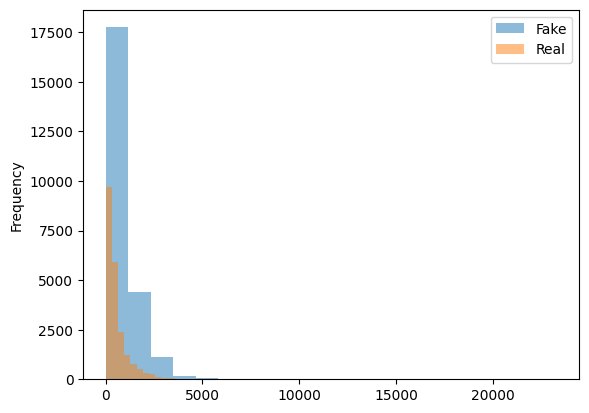

In [15]:
df[fake]['text_len'].plot(kind='hist', bins=20, alpha=0.5, label='Fake', legend=True)
df[~fake]['text_len'].plot(kind='hist', bins=20, alpha=0.5, label='Real', legend=True)

### Target Feature Distribution

In [16]:
len(df[fake]), len(df[~fake])

(23481, 21417)

looks well balanced.

### Subject Split

In [17]:
world_news = df["subject"] == "worldnews"
politics_news = df["subject"] == "politicsNews"

df_world = df[world_news].copy(deep=True)
df_politics = df[politics_news].copy(deep=True)

### Down-Scaling Setup

To check for acuracy variation in different data sizes, an experiment comparing model performance using decreasing amounts of data will be conducted, with four smaller datasets being arranged to compare with the original.

In [18]:
def get_down_scalled_df(df, n):
    return df.sample(n=n, random_state=42)

In [19]:
fake_index = df_world[df_world["real"] == 0].index
real_index = df_world[df_world["real"] == 1].index

world_sections = []
for i in range(1, 9):
    world_sections.append(get_down_scalled_df(df_world, len(df_world) // 2**i))

In [20]:
fake_index = df_politics[df_politics["real"] == 0].index
real_index = df_politics[df_politics["real"] == 1].index

politics_sections = []
for i in range(1, 9):
    politics_sections.append(get_down_scalled_df(df_politics, len(df_politics) // 2**i))

In [21]:
fake_index = df[df["real"] == 0].index
real_index = df[df["real"] == 1].index

sections = []
for i in range(1, 9):
    sections.append(get_down_scalled_df(df, len(df) // 2**i))

## Classifier Evaluation and Testing

In this section contains the pipeline related setups, testing with subject-based sections and downsampling tests.

### Pipeline Setup

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [23]:
def new_pipeline():
    return Pipeline([
        ('Vectorizer', TfidfVectorizer(lowercase=True, stop_words='english')),  
        ('Classifier', LogisticRegression()),  
    ])

In [24]:
# define preprocessing pipeline
pipe_base = new_pipeline()

### Metric Extraction Setup

In [25]:
def relevant_words_sample(vectorizer, classifier):
    words = vectorizer.get_feature_names_out()
    coefs = classifier.coef_
    # classes = classifier.classes_
    sorted_coef_indexes = coefs.argsort(axis=1)


    print('\n')
    print(f"Most relevant for class: 'Fake'\n")
    top5words = words[sorted_coef_indexes[0,:20]]
    print(top5words)
    top5coefs = coefs[0,sorted_coef_indexes[0,:10]]
    print(top5coefs)
    print('\n')
    print(f"Most relevant for class: 'Real'\n")
    last5words = words[sorted_coef_indexes[0,-20:]]
    print(last5words)
    last5coefs = coefs[0,sorted_coef_indexes[0,-10:]]
    print(last5coefs)


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score

In [27]:
def test_pipeline(df, pipe, title):
    X_train, X_test, y_train, y_test = train_test_split(df["text"], df['real'], test_size=0.2)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print(title,"\n", df['real'].value_counts())
    print(classification_report(y_test, y_pred))
    print(balanced_accuracy_score(y_test, y_pred))

### Subject restricted classification

In [28]:
test_pipeline(df, pipe_base, "Complete Dataset")

Complete Dataset 
 real
0    23481
1    21417
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4655
           1       0.96      0.93      0.94      4325

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

0.945207403314231


In [29]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: 'Fake'

['just' 'gop' 'image' 'read' 'elect' 'mr' 'com' 'like' 'american'
 'featured' 'obama' 'america' 'watch' 'video' 'know' 'rep' 'https' 'today'
 'pic' 'thing']
[-6.50724064 -5.35192909 -4.9546572  -4.83670161 -4.8043444  -4.59706477
 -4.48066675 -4.16970141 -4.15337043 -4.00063053]


Most relevant for class: 'Real'

['nov' 'lawmaker' 'representative' 'saturday' 'britain' 'barack'
 'republican' 'edt' 'sunday' 'minister' 'reuters' 'presidential'
 'president' 'friday' 'monday' 'thursday' 'donald' 'tuesday' 'wednesday'
 'said']
[ 6.84331807  6.8707954   7.24589948  7.99222228  8.39304566  8.94246539
  9.13964764  9.1852199   9.73611016 10.35250809]


In [30]:
test_pipeline(df_world, pipe_base, "Complete World News Dataset")

Complete World News Dataset 
 real
0    12181
1    10145
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2395
           1       0.97      0.95      0.96      2071

    accuracy                           0.96      4466
   macro avg       0.96      0.96      0.96      4466
weighted avg       0.96      0.96      0.96      4466

0.9602250584420101


In [31]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: 'Fake'

['trump' 'obama' 'republican' 'american' 'image' 'just' 'clinton' 'like'
 'wing' 'year' 'featured' 'america' 'time' 'hillary' 'know' 'white'
 'according' 'thing' 'elect' 'com']
[-7.21337002 -5.49604649 -4.52979094 -4.47014003 -4.12395831 -4.03060252
 -3.86249185 -3.45834606 -3.01229988 -2.93171582]


Most relevant for class: 'Real'

['british' 'reuters' 'killed' 'parliament' 'police' 'saudi' 'prime'
 'china' 'european' 'opposition' 'britain' 'sunday' 'president' 'friday'
 'tuesday' 'monday' 'thursday' 'minister' 'wednesday' 'said']
[3.90966591 3.96373278 4.42108299 5.42010778 5.53549166 5.55385556
 5.71163673 6.19617539 6.34232485 9.03234645]


In [32]:
test_pipeline(df_politics, pipe_base, "Complete Politics News Dataset")

Complete Politics News Dataset 
 real
0    11300
1    11272
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2249
           1       0.94      0.92      0.93      2266

    accuracy                           0.93      4515
   macro avg       0.94      0.93      0.93      4515
weighted avg       0.94      0.93      0.93      4515

0.9349211594287076


In [33]:
relevant_words_sample(pipe_base['Vectorizer'], pipe_base['Classifier'])



Most relevant for class: 'Fake'

['just' 'read' 'com' 'gop' 'watch' 'mr' 'elect' 'https' 'sen' 'pic' 'know'
 'today' 'video' 'rep' 'like' 'cnn' 'america' 'press' 'say' 've']
[-4.68773893 -3.95401234 -3.92716931 -3.75444923 -3.72350254 -3.71226639
 -3.40869074 -3.2543319  -3.0243634  -2.97792971]


Most relevant for class: 'Real'

['governor' 'lawmaker' 'senate' 'senator' 'barack' 'house' 'democratic'
 'representative' 'edt' 'reuters' 'monday' 'friday' 'said' 'presidential'
 'tuesday' 'thursday' 'president' 'wednesday' 'republican' 'donald']
[6.23039133 6.38273748 6.96165077 7.042854   7.21637762 7.32745687
 7.50355873 7.5747665  7.6358403  9.30555254]


#### Preliminary Conclusion: 

Sectioning the data between subjects does not appear to have significative impact in the models accuracy for this dataset.

### Impacts of size reduction

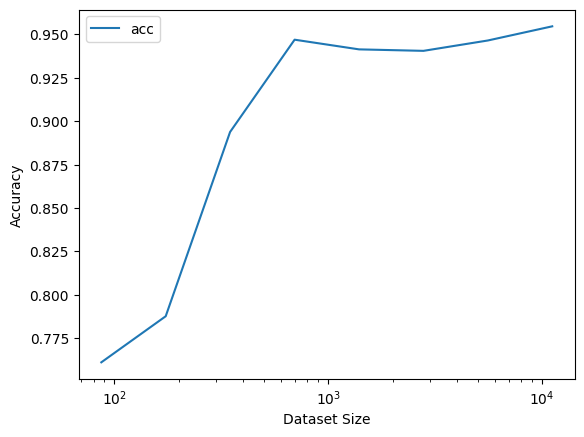

In [61]:
df_acc_world = pd.DataFrame(columns=['section', 'acc'])
# get acc to make a linegraph of the acc of the sections
for i, section in enumerate(world_sections):
    pipe = new_pipeline()
    pipe.fit(section["text"], section["real"])
    X_train, X_test, y_train, y_test = train_test_split(section["text"], section["real"], test_size=0.2)
    y_pred = pipe.predict(X_test)
    df_acc_world.loc[i] = [section.shape[0], cross_val_score(pipe, section["text"], section["real"], cv=5, scoring='balanced_accuracy').mean()]

df_acc_world.plot(x='section', y='acc', logx=True)
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.yscale('linear')

<Axes: xlabel='section'>

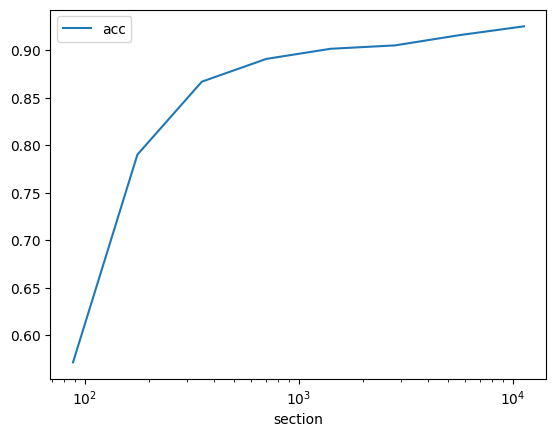

In [62]:
df_acc_politics = pd.DataFrame(columns=['section', 'acc'])

for i, section in enumerate(politics_sections):
    pipe = new_pipeline()
    pipe.fit(section["text"], section["real"])
    X_train, X_test, y_train, y_test = train_test_split(section["text"], section["real"], test_size=0.2)
    y_pred = pipe.predict(X_test)
    df_acc_politics.loc[i] = [section.shape[0], cross_val_score(pipe, section["text"], section["real"], cv=5, scoring='balanced_accuracy').mean()]
df_acc_politics.plot(x='section', y='acc', logx=True)

In [63]:
df_acc = pd.DataFrame(columns=['section', 'acc'])

for i, section in enumerate(sections):
    pipe = new_pipeline()
    print(section.shape)
    pipe.fit(section["text"], section["real"])
    X_train, X_test, y_train, y_test = train_test_split(section["text"], section["real"], test_size=0.2)
    y_pred = pipe.predict(X_test)
    df_acc.loc[i] = [section.shape[0], cross_val_score(pipe, section["text"], section["real"], cv=5, scoring='balanced_accuracy').mean()]

(22449, 7)
(11224, 7)
(5612, 7)
(2806, 7)
(1403, 7)
(701, 7)
(350, 7)
(175, 7)


<Axes: xlabel='section'>

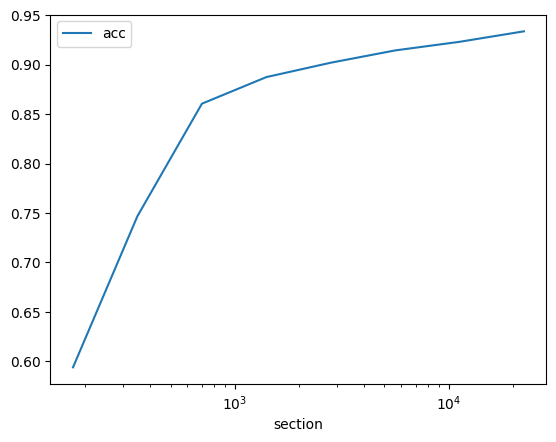

In [64]:
df_acc.plot(x='section', y='acc', logx=True)

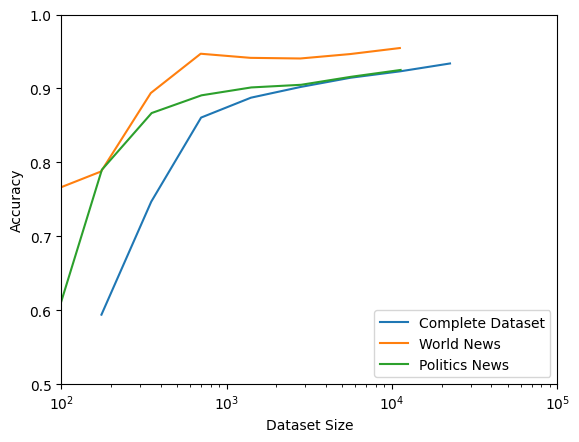

In [73]:
plt.plot(df_acc['section'], df_acc['acc'], label='Complete Dataset')
plt.plot(df_acc_world['section'], df_acc_world['acc'], label='World News')
plt.plot(df_acc_politics['section'], df_acc_politics['acc'], label='Politics News')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.yscale('linear')
plt.axis([10**2, 10**5, 0.5, 1])
#plt.title('Accuracy vs Dataset Size')
plt.legend()
plt.show()

Topic Analysis

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df['real'], test_size=0.2)

from sklearn.decomposition import NMF

vectorizer_nmf_pipeline = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english', binary=True)),
                                ('nmf', NMF(n_components=10)),
                                ('classifier', LogisticRegression(max_iter=1000))])

In [67]:

# param_grid = {
#     'nmf__n_components': [8, 9, 10, 11, 12], # 2-8, best 8, 2-12 best 10
# }

In [68]:
def print_words_in_topics(nmf, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(nmf.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-5:]:
            print(words[i])
        print()
    print()

In [69]:
# from sklearn.model_selection import GridSearchCV

# grid_search_topic = GridSearchCV(vectorizer_nmf_pipeline, param_grid, cv=5, scoring='balanced_accuracy')
# grid_search_topic.fit(X_train, y_train)

# print(grid_search_topic.best_params_)
# print(grid_search_topic.best_score_)

In [70]:
balanced_accuracy_score(y_test, vectorizer_nmf_pipeline.fit(X_train, y_train).predict(X_test))

np.float64(0.8709803908690936)

In [71]:
vectorizer_nmf_pipeline.fit(X_train, y_train)
print_words_in_topics(vectorizer_nmf_pipeline['nmf'], vectorizer_nmf_pipeline['vectorizer'])

Topic 0
budget
fiscal
old
ago
year

Topic 1
wa
image
like
people
just

Topic 2
jae
vice
barack
obama
president

Topic 3
misguided
moralists
masochists
philosophers
evangelists

Topic 4
house
representative
senate
presidential
republican

Topic 5
official
wednesday
united
state
said

Topic 6
theresa
european
al
prime
minister

Topic 7
administration
house
white
donald
trump

Topic 8
american
police
italy
saudi
anti

Topic 9
candidate
democratic
hillary
clinton
presidential




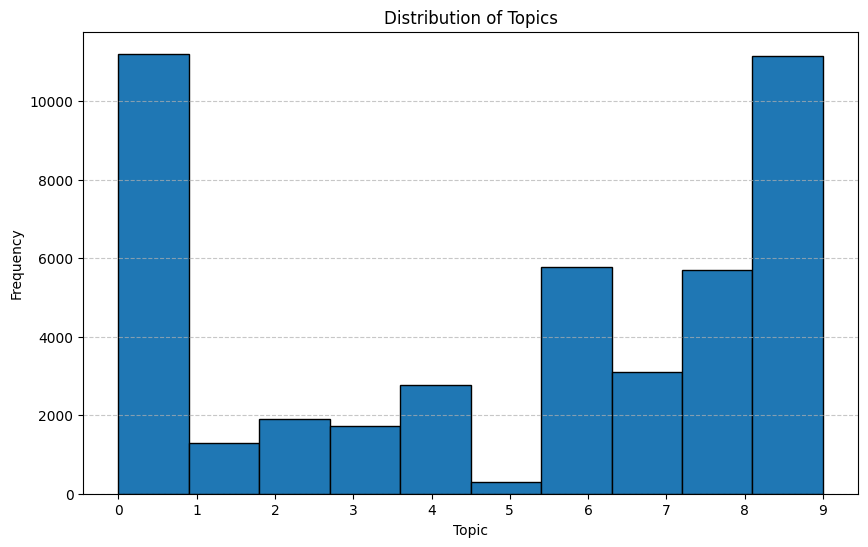

In [72]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X_vec = vectorizer.fit_transform(df['text'])

nmf = NMF(n_components=10)
X_nmf = nmf.fit_transform(X_vec)

topic = np.argmax(X_nmf, axis=1)
plt.figure(figsize=(10, 6))
plt.hist(topic, bins=10, edgecolor='black')
plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()